In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
from nltk.tokenize import sent_tokenize, word_tokenize
  
import math

# **Data Load**

In [54]:
f=open('/content/drive/My Drive/file.txt')

In [55]:
x=[]
y=[]
for l in f:
  t=l.split()
  y.append(int(t.pop()))
  x.append(t)
  
for i in range(len(x)):
  for j in range(len(x[i])):
    x[i][j]=x[i][j].lower()



In [56]:
unique=[]
for i in range(len(x)):
  unique=set(unique).union(set(x[i]))
print(len(unique))


3210


In [57]:
L=[]
for i in range(len(x)):
  d=dict.fromkeys(unique, 0) 
  for words in x[i]:
    d[words]+=1
  L.append(d)
  
  


In [58]:
import pandas as pd
df=pd.DataFrame(L)

# **Function for computing IDF**

In [59]:
def computeIDF(L,unique):
  idf = dict.fromkeys(unique, 0)
  for i in range(len(L)):
    for word in L[i].keys():
      if  L[i][word]>0:
        idf[word]+=1
  N=len(L)
  for key in idf.keys():
    idf[key]=math.log10(N / float(idf[key]+1))
  return idf
  


      
    

# **function for TFIDF**

In [60]:
def computeTFIDF(L,IDF):
  for i in range(len(x)):
    for words in L[i].keys():
      L[i][words]=L[i][words]/len(x[i])*IDF[words]
  return L

  


# **calculating tfidf**

In [61]:
idf=computeIDF(L,unique)
tf_idf=computeTFIDF(L,idf)
import pandas as pd

In [62]:

df1=pd.DataFrame(tf_idf)


# **Standardizing the data**

In [63]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
standard = sc.fit_transform(df1)

# **PCA**

In [64]:
from sklearn.decomposition import PCA
pca=PCA(n_components=10)
pca.fit(standard)
#new is our data after PCA transformation
new=pca.transform(standard)

In [65]:
new.shape

(1000, 10)

In [66]:
idf['young']

2.3010299956639813

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show>

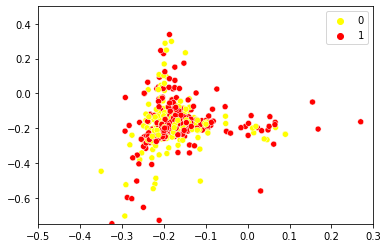

<Figure size 720x720 with 0 Axes>

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(new[:,0],new[:,1],hue=y,palette=['yellow','red'])
plt.xlim(-0.5, 0.3)
plt.ylim(-0.75, 0.5)
plt.figure(figsize=(10,10))
plt.show

# **Initialization**

In [27]:
# from sklearn.cluster import KMeans
# import numpy as np

# km = KMeans(
#     n_clusters=2, init='random',
#     n_init=10, max_iter=300, 
#     tol=1e-04, random_state=0
# )
# y_km = km.fit_predict(new)
# print(np.sum(y_km))

In [68]:
# alpha1=0
# alpha2=1
# c0=[]
# c1=[]
# for i in range(len(y_km)):
#   if(y_km[i]==0):
#     c0.append(new[i])
#   else:
#     c1.append(new[i])

c0=[]
c1=[]
c0=new[:500][:]
c1=new[500:][:]

# from sklearn.model_selection import train_test_split
# c0,c1  = train_test_split(new, test_size=0.5)  
  

In [69]:
len(c0)

500

In [70]:
alpha1=len(c0)/1000
alpha2=len(c1)/1000

In [71]:
import numpy as np

In [84]:
mean1=np.mean(np.array(c0),axis=0)
mean2=np.mean(np.array(c1),axis=0)
var1=np.diag(np.diag(np.cov(np.array(c0).T)))
var2=np.diag(np.diag(np.cov(np.array(c1).T)))

In [73]:
from scipy.stats import multivariate_normal

# **function for log likelihood**

In [85]:
def computeLikeli(likl1,likl2):
  m=np.add(likl1,likl2)
  m=np.where(m>0,m,1)
  log_likl=np.log10(m)
  T_likl=np.sum(log_likl)
  return T_likl
  


# **Function for EM algorithm**

In [89]:
def ComputeEM(alpha1,alpha2,mean1,mean2,var1,var2,new,N,l):
  distribution1 = multivariate_normal(mean=mean1, cov=var1)
  likl1 = distribution1.pdf(new)*alpha1
  distribution2 = multivariate_normal(mean=mean2, cov=var2)
  likl2 = distribution2.pdf(new)*alpha2
  likl1=np.where(likl1>0,likl1,0.5)
  likl2=np.where(likl2>0,likl2,0.5)
  post1=np.divide(likl1,np.add(likl1,likl2))
  post2=np.divide(likl2,np.add(likl1,likl2))
  l.append(computeLikeli(likl1,likl2))
  print("log liklehood",computeLikeli(likl1,likl2))
  y_predict=[]
  for i in range(len(post1)):
    if(post1[i]>post2[i]):
      y_predict.append(0)
    else:
      y_predict.append(1)
  #plotting
  plt.figure(figsize=(10,10))
  sns.scatterplot(x=new[:,0],y=new[:,1],hue=y_predict,palette=['blue','red'])
  plt.xlim(-0.5, 0.3)
  plt.ylim(-0.75, 0.5)
  plt.show

  #calculating new alpha
  new_alpha1=np.mean(post1)
  new_alpha2=np.mean(post2)
  c0=[]
  c1=[]
  
  for i in range(len(new)):
    c0.append(new[i]*post1[i])
    c1.append(new[i]*post2[i])
  
  #calculating new mean
  new_mean1=np.sum(np.array(c0),axis=0)/np.sum(post1)
  new_mean2=np.sum(np.array(c1),axis=0)/np.sum(post2)


  #calculating new diagonal varience
  xx=[]
  for i in range(len(new)):
    xx.append(new[i]- new_mean1)
  for i in range(len(xx)):
    for j in range(len(xx[i])):
      xx[i][j] **=2

  yy=[]
  for i in range(len(new)):
    yy.append(new[i]- new_mean2)
  
  for i in range(len(yy)):
    for j in range(len(yy[i])):
      yy[i][j] **=2


  for i in range(len(xx)):
    xx[i]*=post1[i]
    yy[i]*=post2[i]

  xx_sum = np.sum(xx,axis=0)
  yy_sum = np.sum(yy,axis=0)
  
  # print("post:",N," ",np.sum(post1)," ",np.sum(post2))
  xx_sum /= (np.sum(post1))
  yy_sum /= (np.sum(post2))
  var_new1=np.diag(xx_sum)
  var_new2=np.diag(yy_sum)
  if N-1>0:
    return ComputeEM(new_alpha1,new_alpha2,new_mean1,new_mean2,var_new1,var_new2,new,N-1,l)
  else :
    return y_predict
  


  


  


# **EM algorihtm**

log liklehood -7059.967268812179
log liklehood -7335.981225502615
log liklehood -6525.905534373201
log liklehood -6563.927437313983
log liklehood -6650.754146330462
log liklehood -5496.683015833138
log liklehood -6680.595574594528
log liklehood -5466.930861467854
log liklehood -6685.137173232215
log liklehood -5465.779611480353


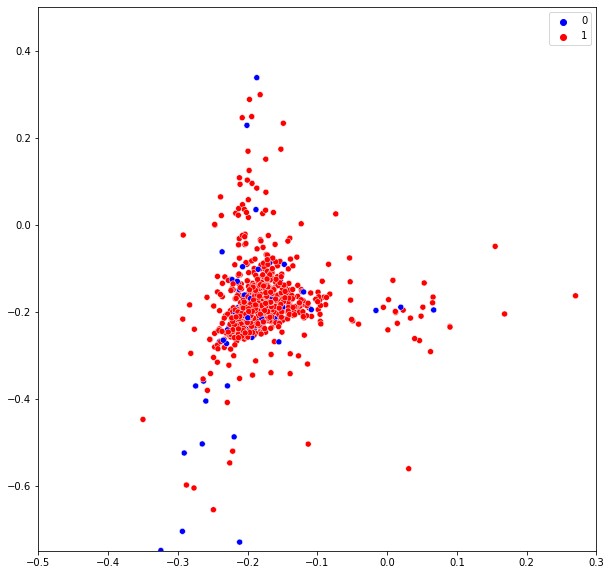

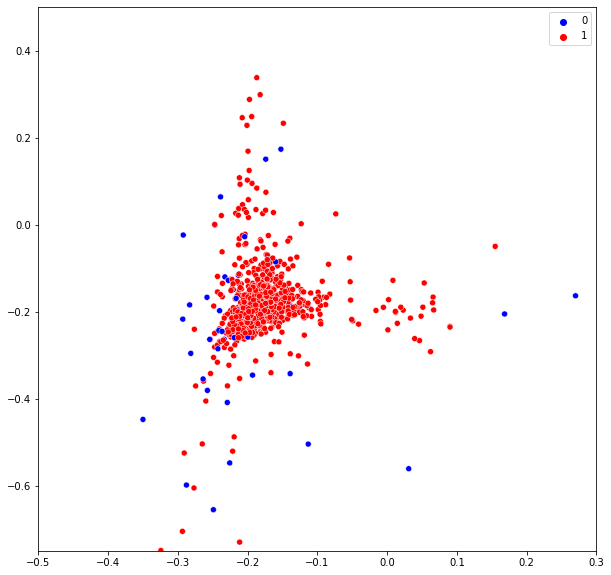

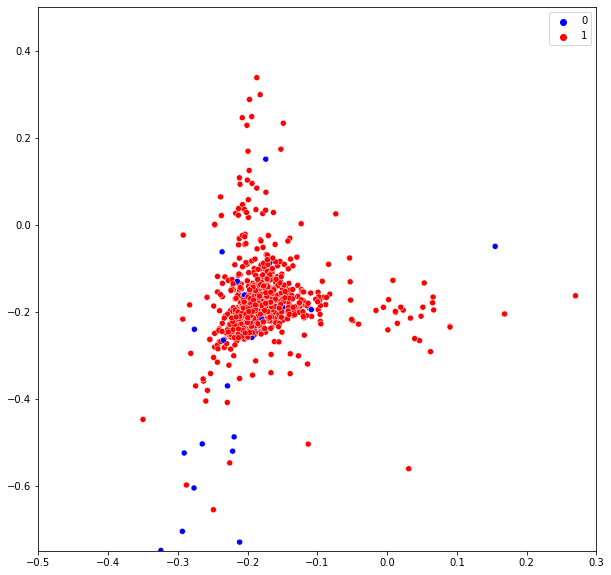

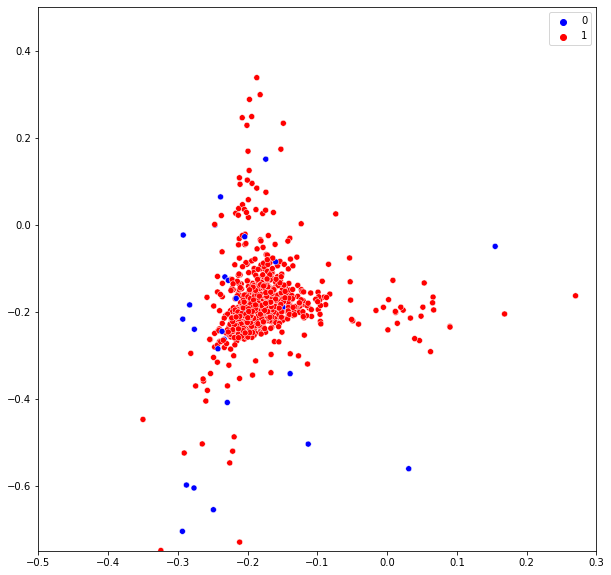

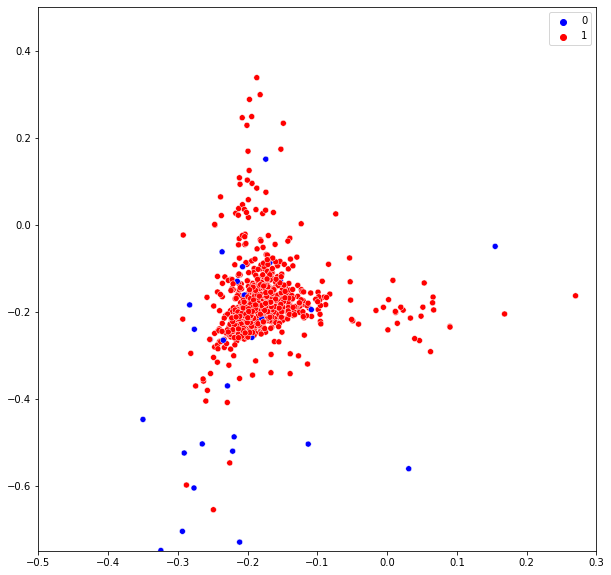

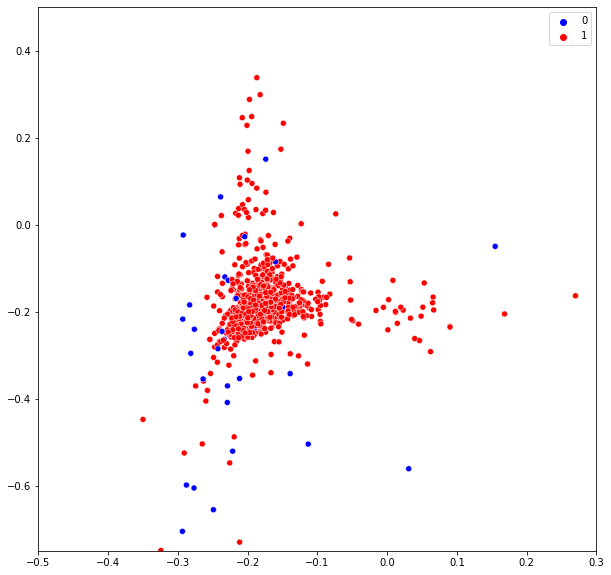

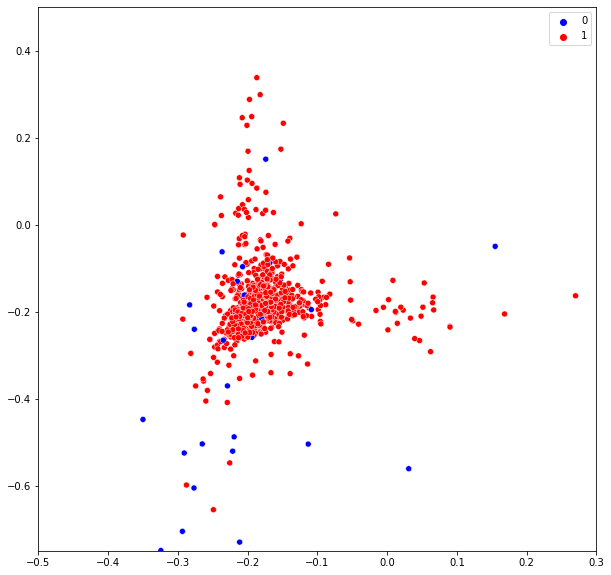

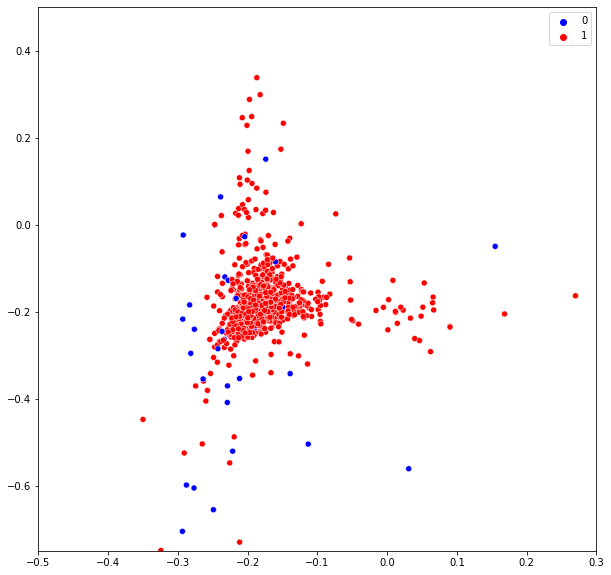

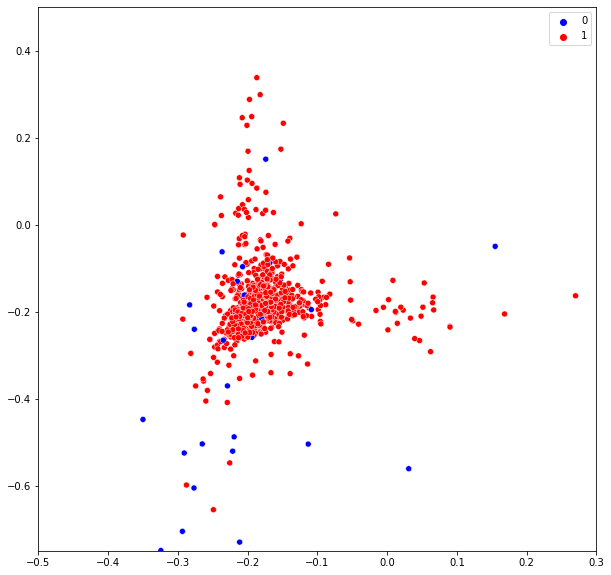

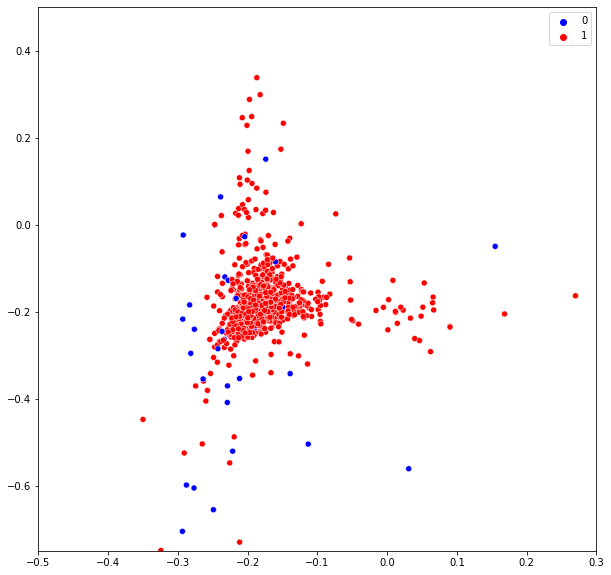

In [91]:
y_predict=ComputeEM(alpha1,alpha2,mean1,mean2,var1,var2,new,10,[]
                    )




In [92]:
print(y_predict)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 

In [93]:
from sklearn.metrics import accuracy_score
print("accuracy:",accuracy_score(y, y_predict))

accuracy: 0.482
